<p style="text-align: center;"><img alt="school-logo" src="../images/school_logo.png" style="zoom: 50%;" /></p>

<h1 align="center">本科生《深度学习》课程<br>实验报告</h1>
<div style="text-align: center;">
    <div><span style="display: inline-block; width: 65px; text-align: center;">课程名称</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">深度学习</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">实验题目</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">网络优化实验</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">学号</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">21281280</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">姓名</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">柯劲帆</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">班级</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">物联网2101班</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">指导老师</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">张淳杰</span></div>
    <div><span style="display: inline-block; width: 65px; text-align: center;">报告日期</span><span style="display: inline-block; width: 25px;">:</span><span style="display: inline-block; width: 210px; font-weight: bold; text-align: left;">2023年11月10日</span></div>
</div>

实验环境：
- OS：Ubuntu 22.04 (Kernel: 6.2.0-34-generic)
- CPU：12th Gen Intel(R) Core(TM) i7-12700H
- GPU：NVIDIA GeForce RTX 3070 Ti Laptop
- cuda: 12.3
- conda: miniconda 23.9.0
- python：3.10.13
- pytorch：2.1.0

In [1]:
import numpy as np
import torch
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

引用必要的库。

# 任务一

**在多分类任务实验中分别手动实现和用torch.nn实现dropout**

- 探究不同丢弃率对实验结果的影响（可用loss曲线进行展示）


In [2]:
def train_MNIST_CLS(model, optimizer, num_epochs):
    batch_size = 512
    num_classes = 10
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )
    train_mnist_dataset = datasets.MNIST(root="./dataset", train=True, transform=transform, download=True)
    test_mnist_dataset = datasets.MNIST(root="./dataset", train=False, transform=transform, download=True)
    train_loader = DataLoader(dataset=train_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)
    test_loader = DataLoader(dataset=test_mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    train_loss = list()
    test_acc = list()
    for epoch in range(num_epochs):
        model.train()
        total_epoch_loss = 0
        for images, targets in train_loader:
            optimizer.zero_grad()

            images = images.to(device)
            targets = targets.to(device)
            one_hot_targets = one_hot(targets, num_classes=num_classes).to(dtype=torch.float)

            outputs = model(images)
            loss = criterion(outputs, one_hot_targets)
            total_epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            total_epoch_acc = 0
            for image, targets in test_loader:
                image = image.to(device)
                targets = targets.to(device)
                
                outputs = model(image)
                pred = softmax(outputs, dim=1)
                total_epoch_acc += (pred.argmax(1) == targets).sum().item()
        
        avg_epoch_acc = total_epoch_acc / len(test_mnist_dataset)
        if epoch % 5 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}],",
                f"Train Loss: {total_epoch_loss:.10f},",
                f"Test Acc: {avg_epoch_acc * 100:.3f}%",
            )
        train_loss.append(total_epoch_loss)
        test_acc.append(avg_epoch_acc * 100)
    return train_loss, test_acc

首先编写训练模型的框架函数代码。

In [3]:
class My_Dropout(nn.Module):
    def __init__(self, p, **kwargs):
        super().__init__()
        self.p = p
        self.mask = None

    def forward(self, x:torch.Tensor):
        if self.training:
            self.mask = (torch.rand(x.shape) > self.p).to(dtype=torch.float32, device=x.device)
            return x * self.mask / (1 - self.p)
        else:
            return x


# 测试
my_dropout = My_Dropout(p=0.5)
nn_dropout = nn.Dropout(p=0.5)
x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0],
                  [6.0, 7.0, 8.0, 9.0, 10.0]])
print(f"输入：\n{x}")
output_my_dropout = my_dropout(x)
output_nn_dropout = nn_dropout(x)
print(f"My_Dropout输出：\n{output_my_dropout}")
print(f"nn.Dropout输出：\n{output_nn_dropout}")

输入：
tensor([[ 1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10.]])
My_Dropout输出：
tensor([[ 2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 16.,  0., 20.]])
nn.Dropout输出：
tensor([[ 2.,  0.,  0.,  0., 10.],
        [ 0., 14., 16.,  0.,  0.]])


手动实现Dropout。

dropout_rate=0.0
Epoch [1/21], Train Loss: 89.2402284741, Test Acc: 84.630%
Epoch [6/21], Train Loss: 28.7833277285, Test Acc: 93.350%
Epoch [11/21], Train Loss: 20.3238681629, Test Acc: 94.430%
Epoch [16/21], Train Loss: 15.3997051790, Test Acc: 96.080%
Epoch [21/21], Train Loss: 12.4143246412, Test Acc: 96.460%
dropout_rate=0.25
Epoch [1/21], Train Loss: 89.8318388164, Test Acc: 86.660%
Epoch [6/21], Train Loss: 29.1959916204, Test Acc: 93.430%
Epoch [11/21], Train Loss: 20.5440069586, Test Acc: 92.780%
Epoch [16/21], Train Loss: 16.1447852328, Test Acc: 95.850%
Epoch [21/21], Train Loss: 13.2362614796, Test Acc: 96.780%
dropout_rate=0.5
Epoch [1/21], Train Loss: 94.0871657729, Test Acc: 85.320%
Epoch [6/21], Train Loss: 30.7469169945, Test Acc: 93.850%
Epoch [11/21], Train Loss: 21.7881924808, Test Acc: 95.350%
Epoch [16/21], Train Loss: 17.3726558685, Test Acc: 96.250%
Epoch [21/21], Train Loss: 14.7027723491, Test Acc: 96.710%
dropout_rate=0.75
Epoch [1/21], Train Loss: 101.070399

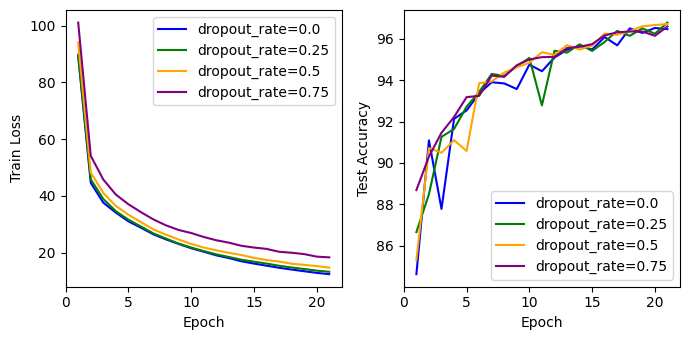

In [4]:
class MNIST_CLS_Model(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


learning_rate = 7e-2
num_epochs = 21
plt.figure(figsize=(7, 3.5))
color = ["blue", "green", "orange", "purple"]
for i in np.arange(4):
    dropout_rate = i / 4
    model = MNIST_CLS_Model(num_classes=10, dropout_rate=dropout_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print(f"dropout_rate={dropout_rate}")
    train_loss, test_acc = train_MNIST_CLS(model, optimizer, num_epochs=num_epochs)
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_loss, label=f'dropout_rate={dropout_rate}', color=color[i])
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), test_acc, label=f'dropout_rate={dropout_rate}', color=color[i])
plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

可以看出，丢弃率越高，loss就会越高，因为丢弃部分神经元会导致网络在训练时失去了一些有用的信息，因为每个神经元都对模型的表达能力有贡献。如果丢弃率很高，网络可能无法充分利用所有的特征，导致信息的损失。

但是，丢弃率越高，测试集的正确率提升相对更稳定。因为高丢弃率使得模型更多地依赖于共享的特征而不是过分依赖于个别神经元，有助于防止过拟合。